<a href="https://colab.research.google.com/github/erinchen41/CIC/blob/main/Alpha2_ROE_DE_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Imports and Setup**

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import os
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import StandardScaler
import joblib
import datetime
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import matplotlib.pyplot as plt

# File paths and date ranges
price_data_path = 'price_data.csv'
features_path = 'features_data.csv'
scaler_path = 'scaler.joblib'
sp500_index_path = 'sp500_index.csv'
X_train_scaled_path = 'X_train_scaled.joblib'
X_val_scaled_path = 'X_val_scaled.joblib'
X_test_scaled_path = 'X_test_scaled.joblib'
y_train_path = 'y_train.joblib'
y_val_path = 'y_val.joblib'
y_test_path = 'y_test.joblib'

# Define periods
train_start = '2018-01-01'
train_end = '2021-12-31'
val_start = '2021-12-31'
val_end = '2022-12-31'
test_start = '2022-12-31'
test_end = '2023-12-31'
data_start = '2017-01-01'

**Data Fetching Functions**

In [ ]:
# Fetch S&P 500 tickers
def fetch_sp500_tickers():
    print("Fetching S&P500 tickers...")
    tickers = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]['Symbol'].tolist()
    tickers = [t.replace('BRK.B', 'BRK-B').replace('BF.B', 'BF-B') for t in tickers]
    return tickers

# Fetch price data
def fetch_price_data(tickers):
    if os.path.exists(price_data_path):
        print("Loading existing price data...")
        return pd.read_csv(price_data_path, index_col='Date', parse_dates=True)
    print("Downloading price data...")
    data = yf.download(tickers, start=data_start, end=test_end, auto_adjust=True, threads=True)['Close']
    data = data.dropna(axis=1, thresh=int(0.9 * len(data)))
    data.to_csv(price_data_path)
    print(f"Saved price data for {len(data.columns)} tickers")
    return data

# Fetch S&P 500 index
def fetch_sp500_index():
    if os.path.exists(sp500_index_path):
        print("Loading S&P500 index data...")
        return pd.read_csv(sp500_index_path, index_col='Date', parse_dates=True)
    print("Downloading S&P500 index data...")
    sp500 = yf.download('^GSPC', start=data_start, end=test_end, auto_adjust=True)['Close']
    sp500.to_csv(sp500_index_path)
    print(f"Saved S&P500 index data")
    return sp500

# Get fundamentals
def get_fundamentals(ticker):
    try:
        t = yf.Ticker(ticker)
        info = t.info
        roe = info.get('returnOnEquity', None)
        debt_to_equity = info.get('debtToEquity', None)
        return roe, debt_to_equity
    except Exception as e:
        print(f"Error fetching fundamentals for {ticker}: {e}")
        return None, None

**Feature Engineering Functions**

In [ ]:
# Calculate technical indicators
def calculate_indicators(close):
    sma20 = close.rolling(20).mean()
    sma50 = close.rolling(50).mean()
    sma200 = close.rolling(200).mean()
    sma_ratio = sma20 / sma50 - 1
    delta = close.diff()
    gain = delta.where(delta > 0, 0).rolling(14).mean()
    loss = -delta.where(delta < 0, 0).rolling(14).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    ema12 = close.ewm(span=12).mean()
    ema26 = close.ewm(span=26).mean()
    macd = ema12 - ema26
    signal = macd.ewm(span=9).mean()
    macd_hist = macd - signal
    volatility = close.pct_change().rolling(30).std() * np.sqrt(252)
    std20 = close.rolling(20).std()
    bb_width = (sma20 + 2 * std20 - (sma20 - 2 * std20)) / sma20
    return pd.DataFrame({
        'sma_ratio': sma_ratio,
        'rsi': rsi,
        'macd_hist': macd_hist,
        'volatility': volatility,
        'bb_width': bb_width,
        'sma200': sma200
    })

# Calculate ARIMA features
def calculate_arima_features(close, periods=[5, 10, 21]):
    import warnings
    warnings.filterwarnings("ignore")
    arima_features = pd.DataFrame(index=close.index)
    log_close = np.log(close)
    log_returns = log_close.diff().dropna()
    try:
        model = ARIMA(log_returns, order=(1, 0, 1))
        model_fit = model.fit()
        for period in periods:
            forecast = model_fit.forecast(steps=period)
            cumulative_forecast = forecast.sum()
            current_log_price = log_close.iloc[-1]
            predicted_log_price = current_log_price + cumulative_forecast
            predicted_price = np.exp(predicted_log_price)
            current_price = close.iloc[-1]
            predicted_return = (predicted_price / current_price) - 1
            arima_features[f'arima_pred_{period}d'] = np.nan
            arima_features.iloc[-1, arima_features.columns.get_loc(f'arima_pred_{period}d')] = predicted_return
            arima_features[f'arima_pred_{period}d'] = arima_features[f'arima_pred_{period}d'].fillna(method='bfill')
        params = model_fit.params
        arima_features['arima_ar1'] = params.get('ar.L1', 0)
        arima_features['arima_ma1'] = params.get('ma.L1', 0)
        arima_features['arima_const'] = params.get('const', 0)
        arima_features['arima_aic'] = model_fit.aic
        arima_features['arima_volatility'] = log_returns.std() * np.sqrt(252)
    except Exception as e:
        print(f"ARIMA model error: {e}")
        for period in periods:
            arima_features[f'arima_pred_{period}d'] = 0
        arima_features['arima_ar1'] = 0
        arima_features['arima_ma1'] = 0
        arima_features['arima_const'] = 0
        arima_features['arima_aic'] = 0
        arima_features['arima_volatility'] = log_returns.std() * np.sqrt(252) if not log_returns.empty else 0
    return arima_features

# Prepare feature dataset
def prepare_data(price_data, sp500_index, tickers):
    features_list = []
    regime = (sp500_index.rolling(200).mean() > sp500_index).astype(int)
    for ticker in tickers:
        print(f"Processing {ticker}...")
        try:
            close = price_data[ticker].dropna()
            if len(close) < 252:
                print(f"Skipping {ticker}: insufficient data")
                continue
            tech_df = calculate_indicators(close)
            print(f"Calculating ARIMA features for {ticker}...")
            arima_df = calculate_arima_features(close)
            features_df = pd.concat([tech_df, arima_df], axis=1)
            features_df = features_df.loc[:, ~features_df.columns.duplicated()]
            roe, debt_to_equity = get_fundamentals(ticker)
            if roe is None or debt_to_equity is None:
                print(f"Skipping {ticker}: missing fundamentals")
                continue
            features_df['roe'] = roe
            features_df['debt_to_equity'] = debt_to_equity
            features_df['above_sma200'] = (close > features_df['sma200']).astype(int)
            features_df['fund_long'] = ((close > features_df['sma200']) & (roe > 0.20) & (debt_to_equity < 1)).astype(int)
            features_df['fund_short'] = ((close < features_df['sma200']) & (roe < 0.10) & (debt_to_equity > 2)).astype(int)
            features_df['ticker'] = ticker
            features_df['date'] = close.index
            features_df['future_price'] = close.shift(-21)
            features_df['fwd_return'] = (features_df['future_price'] / close) - 1
            feature_cols = list(features_df.columns.difference(['ticker', 'date', 'future_price', 'fwd_return']))
            features_df = features_df.dropna(subset=['fwd_return'] + feature_cols)
            if len(features_df) < 50:
                print(f"Skipping {ticker}: insufficient rows")
                continue
            features_df['label'] = pd.qcut(features_df['fwd_return'], q=[0, 0.25, 0.75, 1], labels=[-1, 0, 1], duplicates='drop').astype(int)
            features_df['regime'] = regime.reindex(features_df.index, method='ffill').fillna(0)
            features_list.append(features_df)
        except Exception as e:
            print(f"Error processing {ticker}: {e}")
    if not features_list:
        raise ValueError("No valid feature data.")
    all_features = pd.concat(features_list, ignore_index=True)
    all_features.to_csv(features_path, index=False)
    print(f"Saved features data")
    return all_features

**Data Fetching and Feature Preparation**

In [ ]:
# Execute data fetching and feature preparation
tickers = fetch_sp500_tickers()
price_data = fetch_price_data(tickers)
sp500_index = fetch_sp500_index()
features_df = prepare_data(price_data, sp500_index, tickers)

Fetching S&P500 tickers...


[*********************100%***********************]  503 of 503 completed
ERROR:yfinance:
3 Failed downloads:
ERROR:yfinance:['SOLV', 'GEV', 'SW']: YFPricesMissingError('possibly delisted; no price data found  (1d 2017-01-01 -> 2023-12-31) (Yahoo error = "Data doesn\'t exist for startDate = 1483246800, endDate = 1703998800")')
[*********************100%***********************]  1 of 1 completed

Saved price data for 481 tickers
Saved S&P500 index data
Processing MMM...
Calculating ARIMA features for MMM...


Processing AOS...
Calculating ARIMA features for AOS...
Processing ABT...
Calculating ARIMA features for ABT...
Processing ABBV...
Calculating ARIMA features for ABBV...
Processing ACN...
Calculating ARIMA features for ACN...
Processing ADBE...
Calculating ARIMA features for ADBE...
Processing AMD...
Calculating ARIMA features for AMD...
Processing AES...
Calculating ARIMA features for AES...
Processing AFL...
Calculating ARIMA features for AFL...
Processing A...
Calculating ARIMA features for A...
Processing APD...
Calculating ARIMA features for APD...
Processing ABNB...
Error processing ABNB: 'ABNB'
Processing AKAM...
Calculating ARIMA features for AKAM...
Processing ALB...
Calculating ARIMA features for ALB...
Processing ARE...
Calculating ARIMA features for ARE...
Processing ALGN...
Calculating ARIMA features for ALGN...
Processing ALLE...
Calculating ARIMA features for ALLE...
Processing LNT...
Calculating ARIMA features for LNT...
Processing ALL...
Calculating ARIMA features for 

**LSTM Training**

In [ ]:
# Train LSTM model
def train_lstm(features_df):
    base_cols = ['sma_ratio', 'rsi', 'macd_hist', 'volatility', 'bb_width', 'roe', 'debt_to_equity',
                 'above_sma200', 'fund_long', 'fund_short', 'regime']
    arima_cols = [col for col in features_df.columns if col.startswith('arima_')]
    X_cols = base_cols + arima_cols
    print(f"Training LSTM with {len(X_cols)} features, including {len(arima_cols)} ARIMA features")
    features_df['date'] = pd.to_datetime(features_df['date'])
    train_df = features_df[(features_df['date'] >= train_start) & (features_df['date'] <= train_end)]
    val_df = features_df[(features_df['date'] > train_end) & (features_df['date'] <= val_end)]
    test_df = features_df[(features_df['date'] > val_end) & (features_df['date'] <= test_end)]
    X_train, y_train = train_df[X_cols], train_df['label']
    X_val, y_val = val_df[X_cols], val_df['label']
    X_test, y_test = test_df[X_cols], test_df['label']
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    joblib.dump(scaler, scaler_path)
    joblib.dump(X_train_scaled, X_train_scaled_path)
    joblib.dump(X_val_scaled, X_val_scaled_path)
    joblib.dump(X_test_scaled, X_test_scaled_path)
    joblib.dump(y_train, y_train_path)
    joblib.dump(y_val, y_val_path)
    joblib.dump(y_test, y_test_path)
    print("Saved scaled data and labels")
    sequence_length = 20
    def create_sequences(X, y, seq_len):
        Xs, ys = [], []
        for i in range(len(X) - seq_len):
            Xs.append(X[i:(i+seq_len)])
            ys.append(y.iloc[i+seq_len])
        return np.array(Xs), np.array(ys)
    X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train, sequence_length)
    X_val_seq, y_val_seq = create_sequences(X_val_scaled, y_val, sequence_length)
    X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test, sequence_length)
    y_train_seq = pd.get_dummies(y_train_seq).values
    y_val_seq = pd.get_dummies(y_val_seq).values
    y_test_seq = pd.get_dummies(y_test_seq).values
    lstm = Sequential([
        LSTM(50, return_sequences=True, input_shape=(sequence_length, len(X_cols))),
        Dropout(0.2),
        LSTM(50),
        Dropout(0.2),
        Dense(3, activation='softmax')
    ])
    lstm.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    lstm.fit(X_train_seq, y_train_seq, epochs=10, batch_size=32, validation_data=(X_val_seq, y_val_seq), verbose=1)
    lstm_val_acc = lstm.evaluate(X_val_seq, y_val_seq, verbose=0)[1]
    print(f"LSTM Validation Accuracy: {lstm_val_acc:.4f}")
    lstm.save('lstm_model.h5')
    return X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test

# Execute LSTM training
X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test = train_lstm(features_df)

Training LSTM with 19 features, including 8 ARIMA features
Saved scaled data and labels
Epoch 1/10
13512/13512 ━━━━━━━━━━━━━━━━━━━━ 370s 27ms/step - accuracy: 0.5412 - loss: 0.9877 - val_accuracy: 0.3835 - val_loss: 1.3666
Epoch 2/10
13512/13512 ━━━━━━━━━━━━━━━━━━━━ 368s 26ms/step - accuracy: 0.5618 - loss: 0.9427 - val_accuracy: 0.3753 - val_loss: 1.5660
Epoch 3/10
13512/13512 ━━━━━━━━━━━━━━━━━━━━ 379s 26ms/step - accuracy: 0.5687 - loss: 0.9244 - val_accuracy: 0.3847 - val_loss: 1.5997
Epoch 4/10
13512/13512 ━━━━━━━━━━━━━━━━━━━━ 348s 26ms/step - accuracy: 0.5770 - loss: 0.9079 - val_accuracy: 0.3767 - val_loss: 1.7395
Epoch 5/10
13512/13512 ━━━━━━━━━━━━━━━━━━━━ 382s 26ms/step - accuracy: 0.5825 - loss: 0.8938 - val_accuracy: 0.3786 - val_loss: 1.7357
Epoch 6/10
13512/13512 ━━━━━━━━━━━━━━━━━━━━ 384s 26ms/step - accuracy: 0.5910 - loss: 0.8765 - val_accuracy: 0.3731 - val_loss: 1.7883
Epoch 7/10
13512/13512 ━━━━━━━━━━━━━━━━━━━━ 349s 26ms/step - accuracy: 0.5973 - loss: 0.8653 - val_acc

LSTM Validation Accuracy: 0.3654


**Prediction Aggregation**

In [ ]:
# Aggregate LSTM predictions
def aggregate_predictions(features_df, scaler):
    base_cols = ['sma_ratio', 'rsi', 'macd_hist', 'volatility', 'bb_width', 'roe', 'debt_to_equity',
                 'above_sma200', 'fund_long', 'fund_short', 'regime']
    arima_cols = [col for col in features_df.columns if col.startswith('arima_')]
    X_cols = base_cols + arima_cols
    print(f"Making predictions with {len(X_cols)} features")
    X_full = features_df[X_cols]
    X_full_scaled = scaler.transform(X_full)
    lstm = load_model('lstm_model.h5')
    seq_len = 20
    def create_sequences(X, seq_len):
        Xs = []
        for i in range(len(X) - seq_len):
            Xs.append(X[i:(i+seq_len)])
        return np.array(Xs)
    X_full_seq = create_sequences(X_full_scaled, seq_len)
    lstm_preds_prob = lstm.predict(X_full_seq, verbose=0)
    lstm_preds = np.argmax(lstm_preds_prob, axis=1) - 1
    pred_df = features_df.iloc[seq_len:].copy()
    pred_df['lstm_pred'] = lstm_preds
    for period in [5, 10, 21]:
        col = f'arima_pred_{period}d'
        if col in pred_df.columns:
            pred_df[f'arima_{period}d_signal'] = np.where(
                pred_df[col] > 0.01, 1,
                np.where(pred_df[col] < -0.01, -1, 0)
            )
    pred_df.to_csv('model_predictions.csv', index=False)
    print("Saved model predictions")
    return pred_df

# Execute prediction aggregation
scaler = joblib.load(scaler_path)
pred_df = aggregate_predictions(features_df, scaler)

Making predictions with 19 features


Saved model predictions


**Portfolio Construction**

In [ ]:
# Construct portfolio
def construct_portfolio(pred_df, n_long=10, n_short=10):
    print("Constructing portfolio...")
    pred_df['date'] = pd.to_datetime(pred_df['date'])
    pred_df['year_month'] = pred_df['date'].dt.to_period('M')
    portfolio_list = []
    for period, group in pred_df.groupby('year_month'):
        group_long = group[(group['above_sma200'] == 1) & (group['roe'] > 0.20) & (group['debt_to_equity'] < 1)]
        group_short = group[(group['above_sma200'] == 0) & (group['roe'] < 0.10) & (group['debt_to_equity'] > 2)]
        group_long_sorted = group_long.sort_values('lstm_pred', ascending=False)
        group_short_sorted = group_short.sort_values('lstm_pred', ascending=True)
        if len(group_long_sorted) < n_long or len(group_short_sorted) < n_short:
            print(f"Period {period}: Not enough candidates.")
            continue
        long_stocks = group_long_sorted.head(n_long)[['ticker', 'date', 'lstm_pred']]
        long_stocks['position'] = 'long'
        short_stocks = group_short_sorted.head(n_short)[['ticker', 'date', 'lstm_pred']]
        short_stocks['position'] = 'short'
        print(f"\n{period} Long Positions:")
        print(long_stocks[['ticker', 'lstm_pred']])
        print(f"{period} Short Positions:")
        print(short_stocks[['ticker', 'lstm_pred']])
        month_portfolio = pd.concat([long_stocks, short_stocks])
        month_portfolio['year_month'] = period
        portfolio_list.append(month_portfolio)
    if not portfolio_list:
        raise ValueError("No valid portfolio selections.")
    portfolio_df = pd.concat(portfolio_list, ignore_index=True)
    portfolio_df.to_csv('portfolio_selections.csv', index=False)
    print("Saved portfolio selections")
    return portfolio_df

# Execute portfolio construction
portfolio_df = construct_portfolio(pred_df)

Constructing portfolio...

2017-10 Long Positions:
       ticker  lstm_pred
426435   MPWR          1
64645    ANET          0
64647    ANET          0
64646    ANET          0
64649    ANET          0
64650    ANET          0
64651    ANET          0
64652    ANET          0
64653    ANET          0
64654    ANET          0
2017-10 Short Positions:
       ticker  lstm_pred
9246      AMD         -1
9247      AMD         -1
642045   WELL         -1
642044   WELL         -1
642043   WELL         -1
554262    LUV         -1
554263    LUV         -1
521919    REG         -1
521920    REG         -1
521921    REG         -1

2017-11 Long Positions:
      ticker  lstm_pred
64656   ANET          0
64657   ANET          0
64658   ANET          0
64659   ANET          0
64660   ANET          0
64661   ANET          0
64662   ANET          0
64663   ANET          0
64664   ANET          0
64665   ANET          0
2017-11 Short Positions:
       ticker  lstm_pred
657466    ZBH         -1
657465    

**Portfolio Backtesting**

Backtesting portfolio...

2023-01 Positions:
Long: ['ERIE']
Short: ['MAA', 'AMD', 'DLR']
2023-01 Monthly Return: -0.1206

2023-02 Positions:
Long: ['ERIE', 'MPWR', 'ANET']
Short: ['AVB', 'ADM', 'MDT']
2023-02 Monthly Return: 0.0909

2023-03 Positions:
Long: ['MPWR', 'ANET']
Short: ['CTRA']
2023-03 Monthly Return: 0.1154

2023-04 Positions:
Long: ['MPWR']
Short: ['ALB', 'VTRS', 'TSN', 'SRE', 'RVTY']
2023-04 Monthly Return: -0.0318

2023-05 Positions:
Long: ['MPWR', 'ANET']
Short: ['ALB', 'NWSA', 'NWS']
2023-05 Monthly Return: 0.0129

2023-06 Positions:
Long: ['MPWR', 'ANET']
Short: ['ALB', 'VTR', 'REG']
2023-06 Monthly Return: -0.0862

2023-07 Positions:
Long: ['MPWR']
Short: ['ALB', 'OXY']
2023-07 Monthly Return: 0.0237

2023-08 Positions:
Long: ['ANET']
Short: ['ARE', 'OXY', 'MOS']
2023-08 Monthly Return: 0.3005


[*********************100%***********************]  1 of 1 completed


2023-09 Positions:
Long: ['TPL', 'ERIE', 'ANET', 'MPWR']
Short: ['WBD', 'TDY', 'SWKS']
2023-09 Monthly Return: 0.0587

2023-10 Positions:
Long: ['ERIE', 'ANET']
Short: ['ALB']
2023-10 Monthly Return: 0.2741

2023-11 Positions:
Long: ['ANET', 'TPL', 'MPWR']
Short: ['STZ', 'ED']
2023-11 Monthly Return: 0.0416
Saved portfolio returns


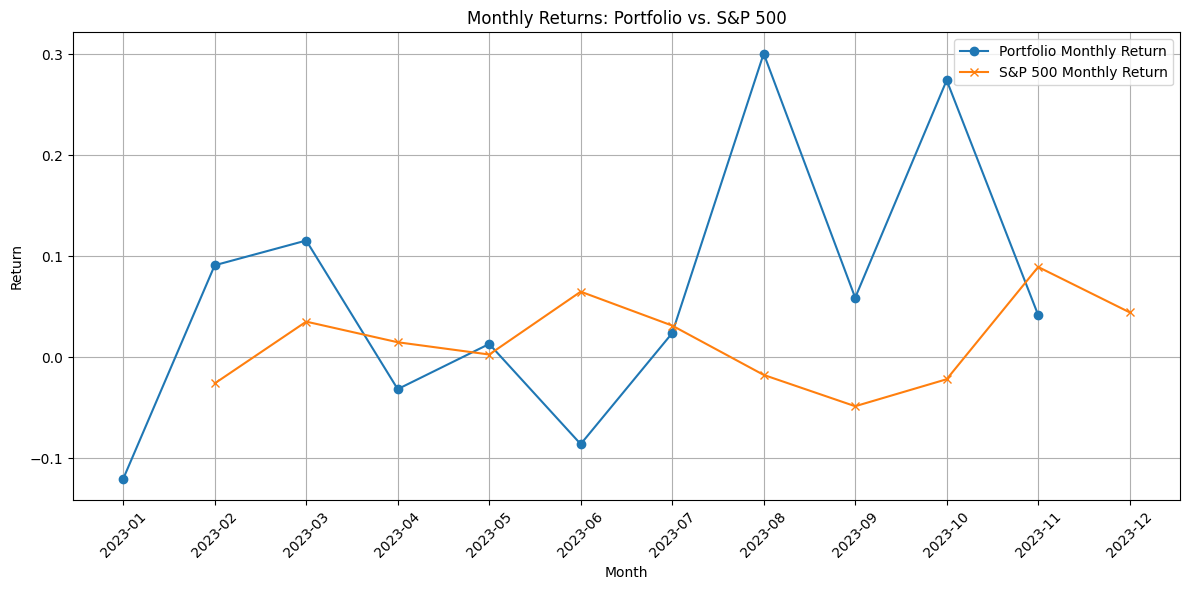

In [ ]:
# Backtest portfolio
def backtest_portfolio(price_data, portfolio_df):
    print("Backtesting portfolio...")
    price_data_test = price_data.loc[test_start:test_end]
    portfolio_df['date'] = pd.to_datetime(portfolio_df['date'])
    portfolio_df = portfolio_df[(portfolio_df['date'] >= test_start) & (portfolio_df['date'] <= test_end)]
    portfolio_df['year_month'] = portfolio_df['date'].dt.to_period('M')
    daily_returns = price_data_test.pct_change().dropna()
    monthly_returns = []
    for period, group in portfolio_df.groupby('year_month'):
        month_start = group['date'].min()
        month_end = month_start + pd.offsets.MonthEnd(0)
        if month_end > pd.to_datetime(test_end):
            month_end = pd.to_datetime(test_end)
        month_ret = daily_returns.loc[month_start:month_end]
        if month_ret.empty:
            continue
        long_tickers = group[group['position'] == 'long']['ticker'].unique().tolist()
        short_tickers = group[group['position'] == 'short']['ticker'].unique().tolist()
        print(f"\n{period} Positions:")
        print("Long:", long_tickers)
        print("Short:", short_tickers)
        long_returns = month_ret[long_tickers].mean(axis=1) if long_tickers else pd.Series()
        short_returns = month_ret[short_tickers].mean(axis=1) if short_tickers else pd.Series()
        if long_returns.empty or short_returns.empty:
            print(f"Skipping {period}: insufficient returns.")
            continue
        long_cum_return = (1 + long_returns).cumprod().iloc[-1] - 1
        short_cum_return = (1 + short_returns).cumprod().iloc[-1] - 1
        portfolio_return = (long_cum_return - short_cum_return)
        print(f"{period} Monthly Return: {portfolio_return:.4f}")
        monthly_returns.append({
            'year_month': str(period),
            'long_return': long_cum_return,
            'short_return': short_cum_return,
            'portfolio_return': portfolio_return
        })
    returns_df = pd.DataFrame(monthly_returns)
    returns_df.to_csv('portfolio_returns.csv', index=False)
    print("Saved portfolio returns")
    sp500 = yf.download('^GSPC', start=test_start, end=test_end, auto_adjust=True)['Close']
    sp500_monthly = sp500.resample('M').last().pct_change().dropna()
    sp500_monthly.index = sp500_monthly.index.to_period('M')
    plt.figure(figsize=(12,6))
    plt.plot(returns_df['year_month'], returns_df['portfolio_return'], marker='o', label='Portfolio Monthly Return')
    plt.plot(sp500_monthly.index.astype(str), sp500_monthly.values, marker='x', label='S&P 500 Monthly Return')
    plt.title('Monthly Returns: Portfolio vs. S&P 500')
    plt.xlabel('Month')
    plt.ylabel('Return')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()
    return returns_df

# Execute backtesting
returns_df = backtest_portfolio(price_data, portfolio_df)

**Performance Evaluation**

[*********************100%***********************]  1 of 1 completed

Evaluating performance...
Saved performance metrics

Portfolio Performance Summary:
Total Return: 0.7935
Annualized Return: 0.8914
Annualized Volatility: 0.4568
Sharpe Ratio: 1.9073
Maximum Drawdown: -0.1038


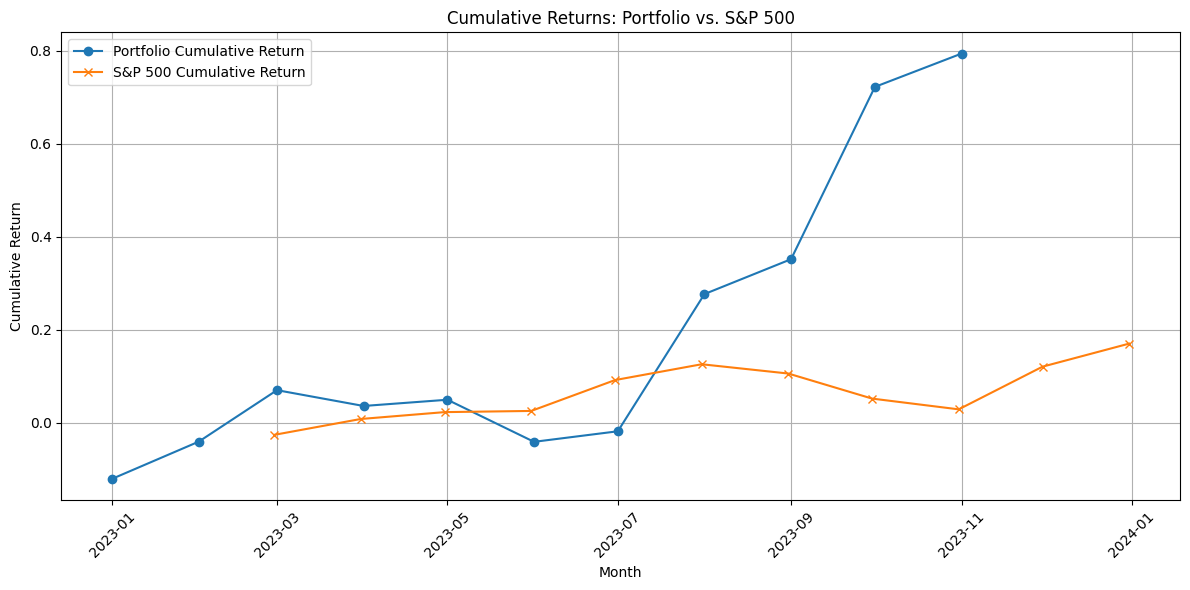

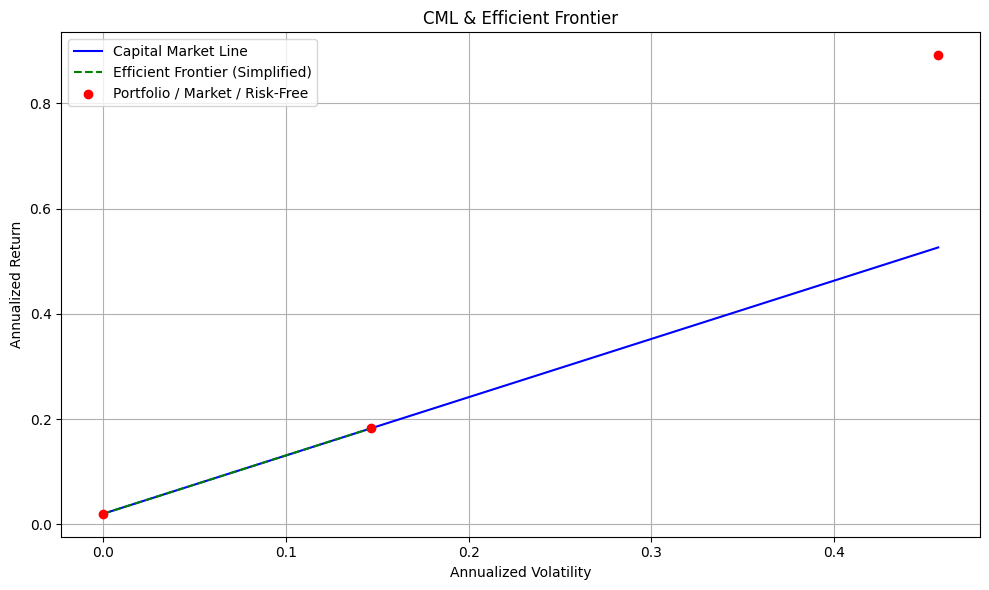

In [ ]:
# Evaluate performance
def evaluate_performance(returns_df, risk_free_rate=0.02):
    print("Evaluating performance...")
    returns_df['year_month'] = pd.to_datetime(returns_df['year_month'])
    returns_df = returns_df.sort_values('year_month')
    returns_df['cumulative_return'] = (1 + returns_df['portfolio_return']).cumprod() - 1
    n_months = len(returns_df)
    total_return = returns_df['cumulative_return'].iloc[-1] if n_months > 0 else 0
    annualized_return = ((1 + total_return) ** (12 / n_months)) - 1 if n_months > 0 else 0
    monthly_vol = returns_df['portfolio_return'].std()
    annualized_vol = monthly_vol * np.sqrt(12) if monthly_vol is not None else 0
    sharpe_ratio = (annualized_return - risk_free_rate) / annualized_vol if annualized_vol != 0 else 0
    cumulative = (1 + returns_df['portfolio_return']).cumprod()
    rolling_max = cumulative.cummax()
    drawdown = (cumulative - rolling_max) / rolling_max
    max_drawdown = drawdown.min()
    performance_metrics = {
        'Total Return': total_return,
        'Annualized Return': annualized_return,
        'Annualized Volatility': annualized_vol,
        'Sharpe Ratio': sharpe_ratio,
        'Maximum Drawdown': max_drawdown
    }
    perf_df = pd.DataFrame([performance_metrics])
    perf_df.to_csv('portfolio_performance.csv', index=False)
    print("Saved performance metrics")
    print("\nPortfolio Performance Summary:")
    for key, value in performance_metrics.items():
        print(f"{key}: {value:.4f}")
    sp500 = yf.download('^GSPC', start=test_start, end=test_end, auto_adjust=True)['Close']
    sp500_monthly_close = sp500.resample('ME').last()
    sp500_monthly_returns = sp500_monthly_close.pct_change().dropna()
    sp500_monthly_cum = (1 + sp500_monthly_returns).cumprod() - 1
    plt.figure(figsize=(12,6))
    plt.plot(returns_df['year_month'], returns_df['cumulative_return'], marker='o', label='Portfolio Cumulative Return')
    plt.plot(sp500_monthly_cum.index, sp500_monthly_cum.values, marker='x', label='S&P 500 Cumulative Return')
    plt.title('Cumulative Returns: Portfolio vs. S&P 500')
    plt.xlabel('Month')
    plt.ylabel('Cumulative Return')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()
    market_return = float(sp500_monthly_returns.mean() * 12)
    market_vol = float(sp500_monthly_returns.std() * np.sqrt(12))
    cml_slope = (market_return - risk_free_rate) / market_vol if market_vol != 0 else 0
    cml_vols = np.linspace(0, max(annualized_vol, market_vol), 100)
    cml_returns = risk_free_rate + cml_slope * cml_vols
    eff_vols = np.linspace(0, market_vol, 100)
    eff_returns = risk_free_rate + (market_return - risk_free_rate) * (eff_vols / market_vol)
    plt.figure(figsize=(10,6))
    plt.plot(cml_vols, cml_returns, label='Capital Market Line', color='blue')
    plt.plot(eff_vols, eff_returns, label='Efficient Frontier (Simplified)', color='green', linestyle='--')
    plt.scatter([annualized_vol, market_vol, 0], [annualized_return, market_return, risk_free_rate],
                color='red', zorder=5, label='Portfolio / Market / Risk-Free')
    plt.title('CML & Efficient Frontier')
    plt.xlabel('Annualized Volatility')
    plt.ylabel('Annualized Return')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()
    return returns_df, performance_metrics

# Execute performance evaluation
returns_df, performance_metrics = evaluate_performance(returns_df)

[*********************100%***********************]  1 of 1 completed
<ipython-input-1-a8d0cc6ce2e0>:13: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  sp500_monthly = sp500.resample('M').last().pct_change().dropna()


S&P 500 Monthly Returns:
Ticker         ^GSPC
Date                
2023-02-28 -0.026112
2023-03-31  0.035052
2023-04-30  0.014642
2023-05-31  0.002482
2023-06-30  0.064727
2023-07-31  0.031139
2023-08-31 -0.017716
2023-09-30 -0.048719
2023-10-31 -0.021980
2023-11-30  0.089179
2023-12-31  0.044229

S&P 500 Cumulative Return:
Ticker         ^GSPC
Date                
2023-02-28 -0.026112
2023-03-31  0.008024
2023-04-30  0.022784
2023-05-31  0.025323
2023-06-30  0.091689
2023-07-31  0.125683
2023-08-31  0.105740
2023-09-30  0.051869
2023-10-31  0.028749
2023-11-30  0.120492
2023-12-31  0.170051


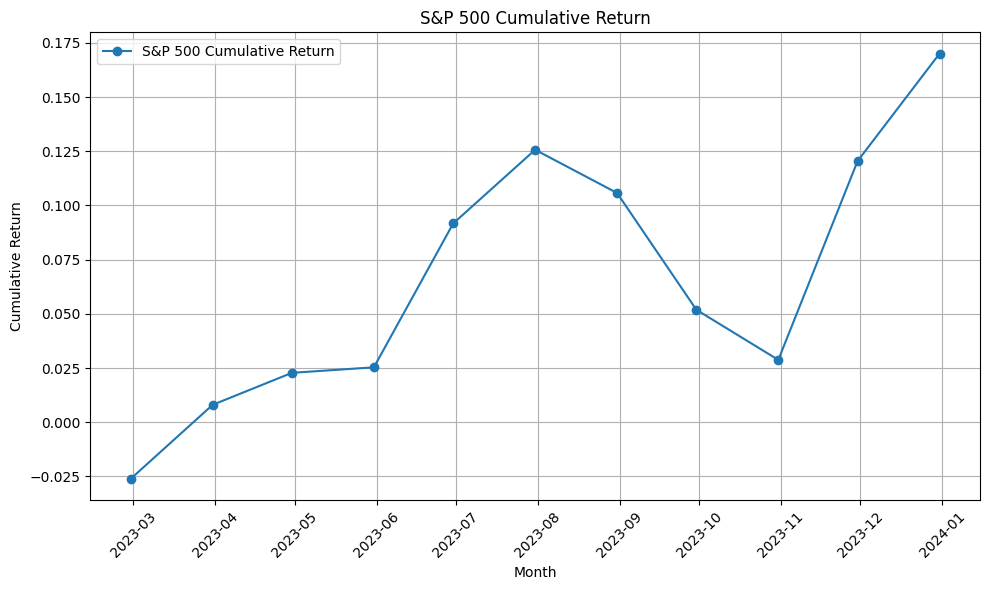

In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# Define your test period
test_start = '2022-12-31'
test_end = '2023-12-31'

# Download S&P 500 index data
sp500 = yf.download('^GSPC', start=test_start, end=test_end, auto_adjust=True)['Close']

# Resample to monthly frequency and calculate returns
sp500_monthly = sp500.resample('M').last().pct_change().dropna()
sp500_cumulative = (1 + sp500_monthly).cumprod() - 1

# Print S&P 500 monthly and cumulative returns
print("S&P 500 Monthly Returns:")
print(sp500_monthly)
print("\nS&P 500 Cumulative Return:")
print(sp500_cumulative)

# Plot S&P 500 cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(sp500_cumulative.index, sp500_cumulative.values, marker='o', label='S&P 500 Cumulative Return')
plt.title('S&P 500 Cumulative Return')
plt.xlabel('Month')
plt.ylabel('Cumulative Return')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()
